In [2]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modeling - Logistic, XGBOOST, SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [3]:
import sys
sys.path.append(f'../../../python')

from balance_split_data import create_label, retain_section, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, \
get_feature_importance, get_feature_importance10

### Load data

In [5]:
df = pd.read_json(r"../../../../data/processed/pre-processed_merged_2023_04_04.json")

### Balance data and split to train and test set

In [6]:
label_name = "phase2"
section_dict={0:'Parties & Operation', 1:'Concentration & Dimension', 
              2:'Market Definition', 3:'Competitive Assessment'}
random_seed=42
random_state=42

In [7]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)


Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406


In [8]:
df_train['section_fin'].value_counts()

Concentration & Dimension    134
Competitive Assessment       129
Parties & Operation          122
Market Definition            113
Name: section_fin, dtype: int64

In [9]:
# retain section
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [10]:
df_train_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         157 non-null    int64 
 1   case_num     157 non-null    object
 2   article_new  157 non-null    object
 3   label        157 non-null    int64 
 4   text_clean   157 non-null    object
dtypes: int64(2), object(3)
memory usage: 6.3+ KB


In [11]:
df_train_grouped = pd.merge(df_train_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])
df_test_grouped = pd.merge(df_test_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])
df_test1_grouped = pd.merge(df_test1_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])
df_excluded_grouped = pd.merge(df_excluded_grouped, merger_info, how='left', left_on=['case_num', 'article_new'], right_on=['case_code', 'article'])

In [12]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Model training (with 10-fold CV) using best parameters from GridSearch

In [27]:
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


In [13]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (1,2), binary = True, max_df = 0.05, norm = 'l2', use_idf = False))
c = 5
# solver = 'liblinear'
model=LinearSVC(C=c)

In [14]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.8535031847133758

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86        79
           1       0.87      0.83      0.85        78

    accuracy                           0.85       157
   macro avg       0.85      0.85      0.85       157
weighted avg       0.85      0.85      0.85       157


CR: (0.8540650406504064, 0.8533755274261603, 0.853408029878618, None)

Confusion matrix:
 [[69 10]
 [13 65]] 

_______________________


 Accuracy: 85.350 
 Precision: 0.867 
 Recall: 0.833 
 F1: 0.850 
 FPR: 0.127 
 ROC_AUC: 0.853


In [21]:
evaluate(y_train, y_predict_train)

Accuracy: 0.8535031847133758

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86        79
           1       0.87      0.83      0.85        78

    accuracy                           0.85       157
   macro avg       0.85      0.85      0.85       157
weighted avg       0.85      0.85      0.85       157


CR: (0.8540650406504064, 0.8533755274261603, 0.853408029878618, None)

Confusion matrix:
 [[69 10]
 [13 65]] 

_______________________


 Accuracy: 85.350 
 Precision: 0.867 
 Recall: 0.833 
 F1: 0.850 
 FPR: 0.127 
 ROC_AUC: 0.853


In [15]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.9242636746143057

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      1406
           1       0.14      0.85      0.24        20

    accuracy                           0.92      1426
   macro avg       0.57      0.89      0.60      1426
weighted avg       0.99      0.92      0.95      1426


CR: (0.5685218243990747, 0.8876600284495022, 0.5997921105971623, None)

Confusion matrix:
 [[1301  105]
 [   3   17]] 

_______________________


 Accuracy: 92.426 
 Precision: 0.139 
 Recall: 0.850 
 F1: 0.239 
 FPR: 0.075 
 ROC_AUC: 0.888


In [16]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.9

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.85      0.89        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40


CR: (0.904040404040404, 0.8999999999999999, 0.899749373433584, None)

Confusion matrix:
 [[19  1]
 [ 3 17]] 

_______________________


 Accuracy: 90.000 
 Precision: 0.944 
 Recall: 0.850 
 F1: 0.895 
 FPR: 0.050 
 ROC_AUC: 0.900


### Confusion matrix and model performance

### Feature importance

In [17]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
1948,france poland,1.298152,1.298152
3780,regard right,0.588292,0.588292
686,committee concentration,0.578543,0.578543
1054,control target,-0.574899,0.574899
2990,opinion advisory,0.507046,0.507046
1419,despite existence,0.499630,0.499630
3415,practice notifying,-0.496816,0.496816
2506,lead doubt,-0.482093,0.482093
784,competing service,0.479639,0.479639
3118,partially overlapping,0.475396,0.475396


In [18]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [22]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

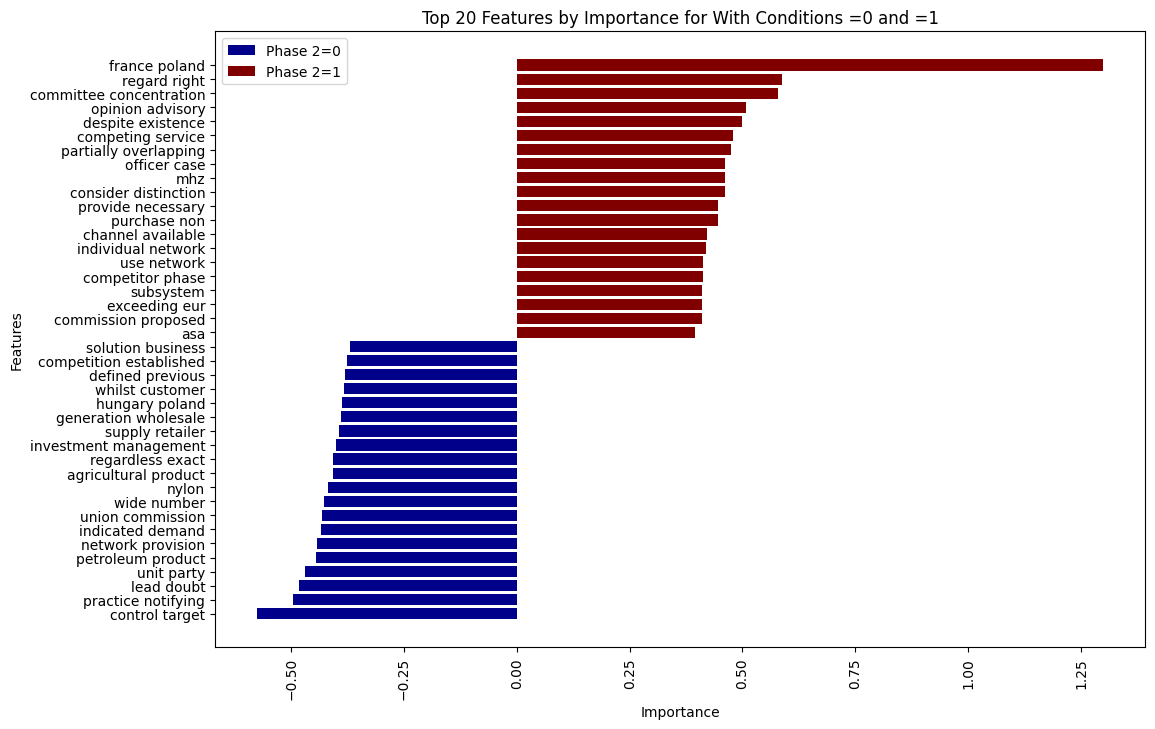

In [24]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='Phase 2=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='Phase 2=1')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Top 20 Features by Importance for With Conditions =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [35]:
df_features_train.to_excel('../../../../output/tables/features_svm_train_full_wc.xlsx', index=True)